## Import Libraries

In [0]:
#Import required libraries
import os

import numpy as np
import pandas as pd

import librosa
import librosa.display

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

import tensorflow as tf
import glob
import IPython.display as ipd
import sys

import keras
from keras import layers
from keras.utils import plot_model
from keras.layers import Activation, Dense, Dropout, Conv2D, Conv1D, Flatten, MaxPooling2D, MaxPooling1D, BatchNormalization
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_json
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

import random

import pickle
import seaborn as sns
import io
from google.colab import files

#from google.colab import drive
#drive.mount('/content/drive')

## Utility functions

In [0]:
#function to parse file and extract corresponding emotion for savee dataset
def tess_data_parser(filepaths, path):
    
  
    audio_item = []
    emotion = []
    classID = []

    for i in filepaths:
        filename = os.listdir(path + i)
        for f in filename:
            if i == 'OAF_angry' or i == 'YAF_angry':
                emotion.append('angry')
                classID.append(1)
            elif i == 'OAF_disgust' or i == 'YAF_disgust':
                emotion.append('disgust')
                classID.append(2)
            elif i == 'OAF_Fear' or i == 'YAF_fear':
                emotion.append('fear')
                classID.append(3)
            elif i == 'OAF_happy' or i == 'YAF_happy':
                emotion.append('happy')
                classID.append(4)
            elif i == 'OAF_neutral' or i == 'YAF_neutral':
                emotion.append('neutral') 
                classID.append(5)                               

            elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
                emotion.append('surprise')   
                classID.append(6)            
            elif i == 'OAF_Sad' or i == 'YAF_sad':
                emotion.append('sad')
                classID.append(7)
            else:
            continue
                audio_item.append(path + i + "/" + f)

    tess_df = pd.DataFrame(emotion, columns = ['emotion'])
    tess_df['classID'] = classID
    tess_df = pd.concat([tess_df,pd.DataFrame(audio_item, columns = ['audio_file'])],axis=1)

    return tess_df

#function to load log mel spectrograms from the data
def load_mel(df, dur=None):

    mel_data = []
    targets = []

    for row in df.itertuples():
        y,sr = librosa.load(row.audio_file)
        duration = librosa.get_duration(y=y, sr=sr)

    if duration >= 2:
        z,sr = librosa.load(row.audio_file, duration = dur)
        mel = librosa.feature.melspectrogram(y=z, sr=sampling_rate, n_mels=128)
        mel_data.append(mel)
        targets.append(row.emotion)

    else:
        continue

    return [mel_data, targets]

#function to load raw data
def load_mel_all(df):

    mel_data = []
    targets = []

    for row in df.itertuples():
        y,sr = librosa.load(row.audio_file)
        mel = librosa.feature.melspectrogram(y=y, sr=sampling_rate, n_mels=128)
        mel_data.append(mel)
        targets.append(row.emotion)

    return [mel_data, targets]



#define CNN model
def compile_model(input_shape):
    model = Sequential()
    #input_shape = (128,87,1)

    model.add(Conv2D(24,(5,5), strides=(1,1), input_shape=input_shape))
    model.add(MaxPooling2D((4,2), strides=(4,2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, (5,5), padding="valid"))
    model.add(MaxPooling2D((4,2), strides=(4,2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, (5,5), padding="valid"))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dropout(rate=0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))

    model.add(Dense(7))
    model.add(Activation('softmax'))  

    model.compile(optimizer="Adam",
              loss="categorical_crossentropy",
              metrics = ['accuracy'])

    return model

#define CNN model
def compile_binary_model(input_shape):
    model = Sequential()
    #input_shape = (128,87,1)

    model.add(Conv2D(24,(5,5), strides=(1,1), input_shape=input_shape))
    model.add(MaxPooling2D((4,2), strides=(4,2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, (5,5), padding="valid"))
    model.add(MaxPooling2D((4,2), strides=(4,2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, (5,5), padding="valid"))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dropout(rate=0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))

    model.add(Dense(2))
    model.add(Activation('softmax'))  

    model.compile(optimizer="Adam",
              loss="binary_crossentropy",
              metrics = ['accuracy'])


    return model
 
#the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# function to get unique values 
def unique(list1): 
    # intilize a null list 
    unique_list = [] 

    # traverse for all elements 
    for x in list1: 
    # check if exists in unique_list or not 
    if x not in unique_list: 
        unique_list.append(x) 
    return unique_list

#function to produce binary representations for each class
def iterator(z):
    main = []
    for i in unique(z):
    d = []
    j = 0
    while j < len(z):
        if i == z[j]:
            d.append(i)
        else:
            d.append("other")
        j+=1
    main.append(d)

    return main

def prepare_data(X, y, lb):

    #split each into train, test and validation

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

    #convert to numpy array 
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_val = np.array(X_val)
    y_val = np.array(y_val)


    #reshape for CNN
    X_train = np.array([x.reshape((128,87,1)) for x in X_train])
    X_val = np.array([x.reshape((128,87,1)) for x in X_val])
    X_test = np.array([x.reshape((128,87,1)) for x in X_test])

    # one hot encode the target 
    y_train = keras.utils.to_categorical(lb.fit_transform(y_train))
    y_test = keras.utils.to_categorical(lb.fit_transform(y_test))
    y_val = keras.utils.to_categorical(lb.fit_transform(y_val))


    return X_train, y_train, X_test, y_test, X_val, y_val

#plot training and testing validation accuracy and loss
def plot_model(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+ 1)

    plt.plot(epochs, acc, 'bo', label='Training acc') 
    plt.plot(epochs, val_acc, 'b', label='Validation acc') 
    plt.title('Training and validation accuracy') 
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss') 
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def fit_model(model, X_train, y_train,X_val, y_val, epochs):

    #define callbacks
    callbacks_list = [
                    keras.callbacks.EarlyStopping(
                        monitor = 'acc',
                        patience = 1
                    )]

    #fit and evaluate model
    history = model.fit(x=X_train,
            y = y_train,
            epochs=epochs,
            batch_size=50,
            callbacks = callbacks_list,
            validation_data = (X_val, y_val))

    score = model.evaluate(x = X_val,
                        y = y_val)

    print('Test loss: ', score[0])
    print('Test accuracy: ', score[1])

    return history, score


def save_model(model,  model_name, filename):
    # Save model and weights
    model_name = model_name
    save_dir = os.path.join(os.getcwd(), 'saved_models')

    if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)
    print('Saving model and weights at %s ' % model_path)

    # Save the model to disk
    model_json = model.to_json()
    with open(filename, "w") as json_file:
        json_file.write(model_json)


def load_model(filename, model_name):
    # loading json and model architecture 
    json_file = open(filename, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights("saved_models/"+ str(model_name))
    print("Loaded model from disk")

    return loaded_model

def OneD_CNN(input_shape):

    model = Sequential()

    model.add(Conv1D(256, 8, padding='same', activation="relu",input_shape=input_shape)) 

    model.add(Conv1D(256, 8, padding='same', activation="relu"))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(8)))

    model.add(Conv1D(128, 8, padding='same', activation="relu"))

    model.add(Conv1D(128, 8, padding='same', activation="relu"))

    model.add(Conv1D(128, 8, padding='same', activation="relu"))

    model.add(Conv1D(128, 8, padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(8)))

    model.add(Conv1D(64, 8, padding='same', activation="relu"))

    model.add(Conv1D(64, 8, padding='same', activation="relu"))

    #model.add(Flatten())

    model.add(layers.LSTM(256))

    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))

    model.add(Dense(7)) 
    model.add(Activation('softmax'))


    model.compile(optimizer="Adam",
              loss="categorical_crossentropy",
              metrics = ['accuracy'])

    return model

def OneD_CNN_binary(input_shape):

    model = Sequential()

    model.add(Conv1D(256, 8, padding='same', activation="relu",input_shape=input_shape)) 

    model.add(Conv1D(256, 8, padding='same', activation="relu"))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(8)))

    model.add(Conv1D(128, 8, padding='same', activation="relu"))

    model.add(Conv1D(128, 8, padding='same', activation="relu"))

    model.add(Conv1D(128, 8, padding='same', activation="relu"))

    model.add(Conv1D(128, 8, padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(8)))

    model.add(Conv1D(64, 8, padding='same', activation="relu"))

    model.add(Conv1D(64, 8, padding='same', activation="relu"))

    #model.add(Flatten())

    model.add(layers.LSTM(256))

    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))

    model.add(Dense(2)) 
    model.add(Activation('softmax'))


    model.compile(optimizer="Adam",
            loss="binary_crossentropy",
            metrics = ['accuracy'])

    return model

## Data Collection and Exploration

In [0]:
#set kaggle api keys
os.environ['KAGGLE_USERNAME'] = "agughalamdavis" # username from the json file
os.environ['KAGGLE_KEY'] = "11e5b15ea10925e1a0b2c694c4040826" # key from the json file

In [0]:
#import TESS dataset
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

100% 428M/428M [00:09<00:00, 55.1MB/s]



In [0]:
#unzip TESS dataset
!unzip /content/toronto-emotional-speech-set-tess.zip -d dataset

In [0]:
#prepare TESS data
tess_data_path = "dataset/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
tess_audio = os.listdir(tess_data_path)
tess_audio.sort()
tess_audio

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [0]:
#view tess dataset
tess_df = tess_data_parser(tess_audio, tess_data_path)
tess_df

,emotion,classID,audio_file
0,fear,3,dataset/tess toronto emotional speech set data...
1,fear,3,dataset/tess toronto emotional speech set data...
2,fear,3,dataset/tess toronto emotional speech set data...
3,fear,3,dataset/tess toronto emotional speech set data...
4,fear,3,dataset/tess toronto emotional speech set data...
...,...,...,...
2795,sad,7,dataset/tess toronto emotional speech set data...
2796,sad,7,dataset/tess toronto emotional speech set data...
2797,sad,7,dataset/tess toronto emotional speech set data...
2798,sad,7,dataset/tess toronto emotional speech set data...


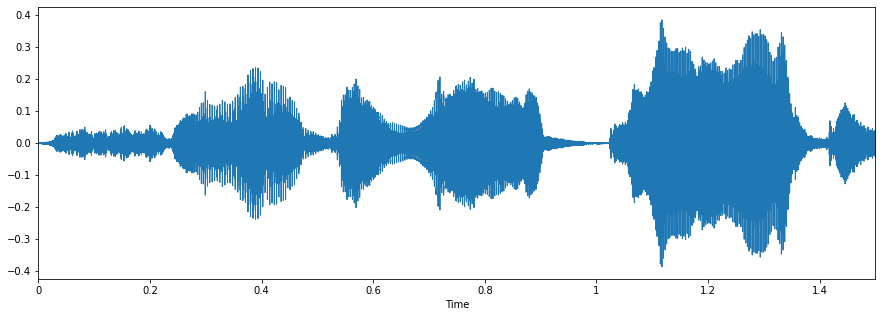

In [0]:
#Explore data TESS

# play a fearful track 
fname = tess_data_path + 'YAF_fear/YAF_dog_fear.wav' 

data, sampling_rate = librosa.load(fname, duration=1.5)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

#play the audio 
ipd.Audio(fname)

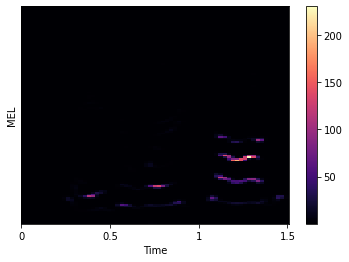

In [0]:
#plot Log Mel spectogram for TESS data sample
mel = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_mels=128)

librosa.display.specshow(mel, x_axis='time')
plt.ylabel('MEL')
plt.colorbar()
plt.show()

## First approach to model training with feature extraction for 2 seconds

In [0]:
#load log mel spectrograms for 2 secs duration of each of the files in the dataset
tess_data = load_mel(tess_df, 2)

In [0]:
#Assign data and targets to variables
X = tess_data[0]
y = tess_data[1]

In [0]:
len(X)

1582

In [0]:
#prepare data
X_train, y_train, X_test, y_test, X_val, y_val, lb = prepare_data(X, y)

In [0]:
y_train.shape

(1138, 7)

In [3]:
#2D CNN model
model = compile_model((128,87,1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 83, 24)       624       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 41, 24)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 31, 41, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 37, 48)        28848     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 18, 48)         0         
_________________________________________________________________
activation_2 (Activation)    (None, 6, 18, 48)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 14, 48)        

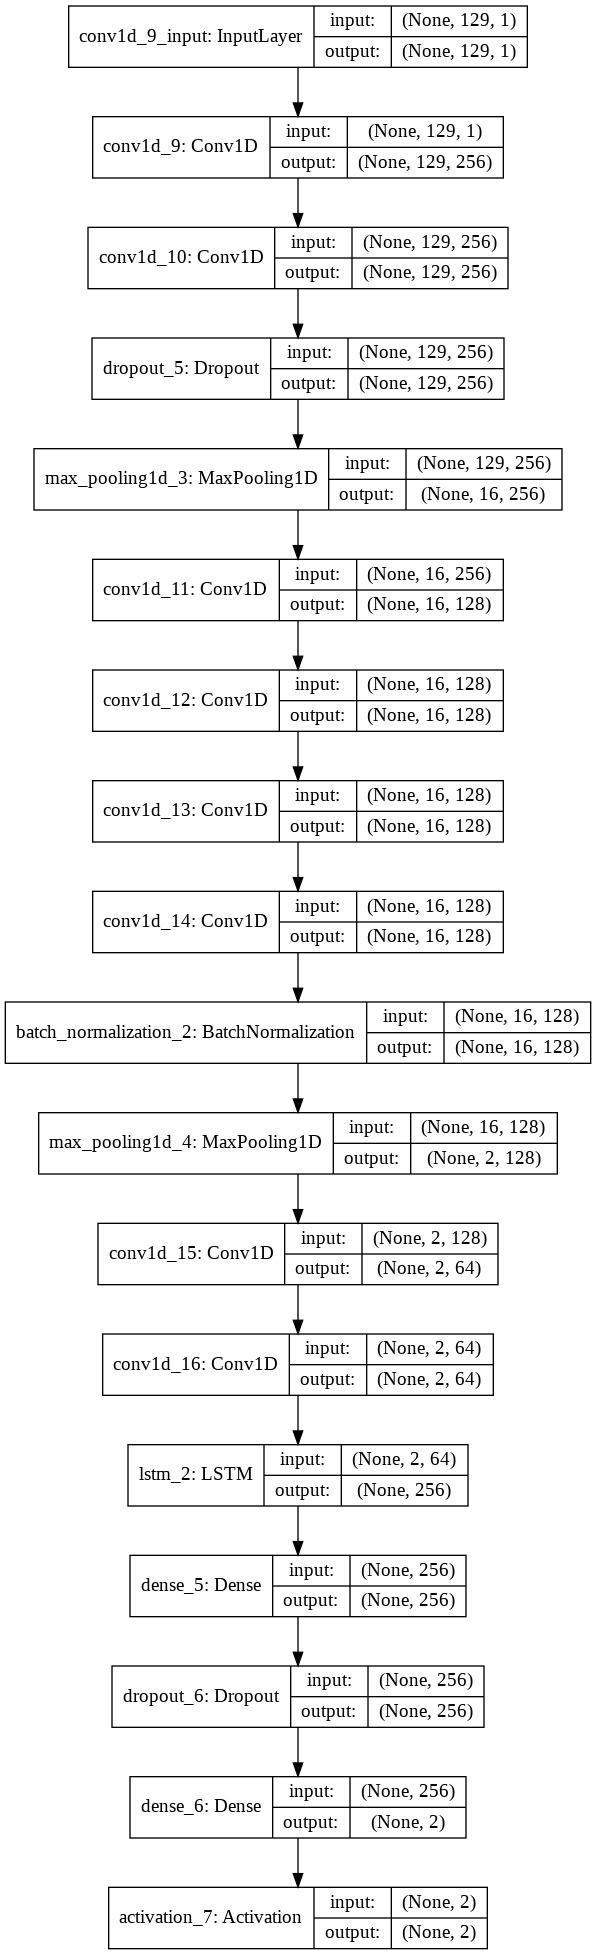

In [20]:
plot_model(model, show_shapes=True,to_file='model_shapes.png')



In [0]:
from google.colab import files
files.download('model.png')

In [0]:
history, score = fit_model(model,X_train, y_train,X_val, y_val)

Train on 1138 samples, validate on 285 samples
Epoch 1/100
1138/1138 [==============================] - 1s 796us/step - loss: 2.1155 - accuracy: 0.3322 - val_loss: 1.2821 - val_accuracy: 0.7053
Epoch 2/100
1138/1138 [==============================] - 1s 515us/step - loss: 1.2910 - accuracy: 0.5536 - val_loss: 0.8455 - val_accuracy: 0.7579
Epoch 3/100
1138/1138 [==============================] - 1s 498us/step - loss: 0.9765 - accuracy: 0.6766 - val_loss: 0.6079 - val_accuracy: 0.8526
Epoch 4/100
1138/1138 [==============================] - 1s 497us/step - loss: 0.7823 - accuracy: 0.7373 - val_loss: 0.4816 - val_accuracy: 0.8947
Epoch 5/100
1138/1138 [==============================] - 1s 498us/step - loss: 0.6583 - accuracy: 0.7900 - val_loss: 0.4184 - val_accuracy: 0.9228
Epoch 6/100
1138/1138 [==============================] - 1s 503us/step - loss: 0.4628 - accuracy: 0.8568 - val_loss: 0.2577 - val_accuracy: 0.9474
Epoch 7/100
1138/1138 [==============================] - 1s 501us/step 

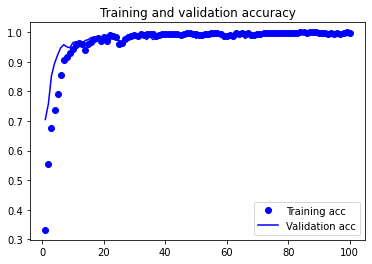

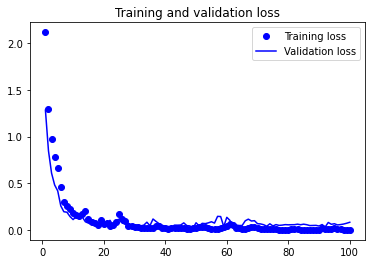

In [0]:
plot_model(history)


In [0]:
#use model to make predictions
preds = model.predict(X_test, 
                      batch_size=50, 
                      verbose=1)

preds=preds.argmax(axis=1)
preds

159/159 [==============================] - 0s 419us/step


array([3, 1, 6, 5, 5, 4, 5, 5, 0, 6, 5, 1, 4, 5, 1, 3, 1, 6, 3, 1, 4, 5,
       1, 5, 6, 3, 1, 4, 5, 1, 6, 3, 4, 5, 1, 5, 1, 6, 5, 1, 3, 3, 5, 1,
       4, 1, 6, 5, 5, 1, 1, 5, 4, 4, 5, 3, 0, 4, 6, 1, 4, 1, 5, 1, 5, 3,
       5, 0, 6, 5, 1, 0, 4, 6, 4, 4, 4, 4, 4, 5, 5, 5, 4, 1, 6, 5, 1, 1,
       1, 5, 5, 6, 4, 0, 4, 5, 3, 1, 1, 6, 6, 4, 1, 1, 1, 3, 1, 3, 1, 3,
       6, 1, 1, 5, 5, 0, 4, 0, 1, 4, 0, 1, 4, 1, 1, 5, 1, 1, 4, 0, 5, 6,
       6, 1, 6, 4, 1, 4, 3, 3, 1, 6, 6, 1, 1, 4, 5, 5, 4, 5, 4, 1, 1, 4,
       1, 0, 5, 5, 1])

In [0]:
# view predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

preds

,predictedvalues
0,happy
1,disgust
2,surprise
3,sad
4,sad
...,...
154,disgust
155,angry
156,sad
157,sad


In [0]:
#compare predicted to actual values

actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

finaldf = actual.join(preds)
finaldf

,actualvalues,predictedvalues
0,happy,happy
1,disgust,disgust
2,surprise,surprise
3,sad,sad
4,sad,sad
...,...,...
154,disgust,disgust
155,angry,angry
156,sad,sad
157,sad,sad


0.9811320754716981


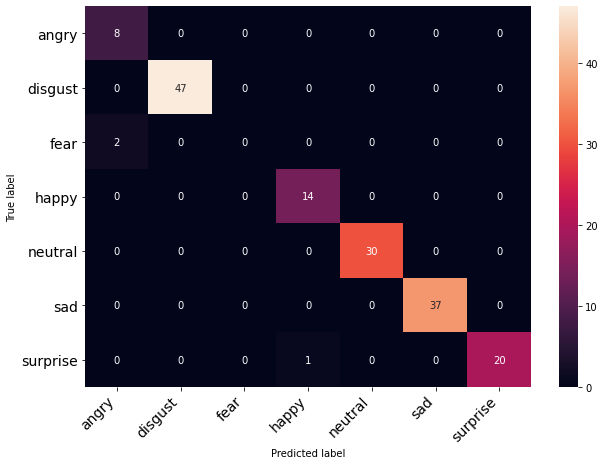

In [0]:
#view confusion matrix
classes = finaldf.actualvalues.unique()
classes.sort()    

c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [0]:
#save and load model
save_model(model, "second_all", "second_allclass")

loaded = load_model("second_allclass.json", "second_all")

**Binary Ensembles**

In [0]:
#make binary representations for each class
binary_rep = iterator(y)

In [0]:
def binary_models(classname):
    #split data into test and train
    lb = LabelEncoder()
    X_train, y_train, X_test, y_test, X_val, y_val = prepare1D(X, d)

    #compile the model
    model = OneD_CNN_binary((129,1))

    #fit the model
    history, score = fit_model(model,X_train, y_train, X_val, y_val )

    print(f"The accuracy of the model is {score[1]}")

    #save the model
    filename = classname + ".json"
    model_name = classname + ".h5"
    save_model(model,model_name,filename)

    return X_test, y_test, lb

In [0]:
all_binary_models = []

for d in binary_rep:
    #get unique classes
    classes = unique(d)
    if classes[1] == 'other':
        classname = classes[0]
    else:
        classname = classes[1]

    model_result = binary_models(classname)
    all_binary_models.append(model_result)
    

Train on 1138 samples, validate on 285 samples
Epoch 1/100
1138/1138 [==============================] - 1s 959us/step - loss: 0.0553 - accuracy: 0.9868 - val_loss: 0.1614 - val_accuracy: 0.9895
Epoch 2/100
1138/1138 [==============================] - 1s 546us/step - loss: 0.0270 - accuracy: 0.9982 - val_loss: 0.1614 - val_accuracy: 0.9895
Epoch 3/100
1138/1138 [==============================] - 1s 521us/step - loss: 0.0270 - accuracy: 0.9982 - val_loss: 0.1614 - val_accuracy: 0.9895
Epoch 4/100
1138/1138 [==============================] - 1s 519us/step - loss: 0.0270 - accuracy: 0.9982 - val_loss: 0.1614 - val_accuracy: 0.9895
Epoch 5/100
1138/1138 [==============================] - 1s 525us/step - loss: 0.0270 - accuracy: 0.9982 - val_loss: 0.1614 - val_accuracy: 0.9895
Epoch 6/100
1138/1138 [==============================] - 1s 524us/step - loss: 0.0270 - accuracy: 0.9982 - val_loss: 0.1614 - val_accuracy: 0.9895
Epoch 7/100
1138/1138 [==============================] - 1s 518us/step 

In [0]:
angry = load_model("angry.json", "angry.h5")

Loaded model from disk


### Second Approach to model training using the full length of the recordings

**Load all the data and take mean of the time axis to reduce dimensions**

In [0]:
tess_all = load_mel_all(tess_df)

In [0]:
X = tess_all[0]
y = tess_all[1]

In [0]:
f = [np.mean(c, axis=0) for c in X]

In [0]:
s = pd.DataFrame(f)
s

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128
0,0.000047,0.000167,0.000379,0.000651,0.000919,0.001331,0.002198,0.002540,0.002035,0.008634,0.121985,0.316862,0.545787,0.932521,0.799249,0.514286,0.320100,0.235932,0.243287,0.281043,0.287845,0.238824,0.139196,0.102248,0.151891,0.184855,0.190610,0.174902,0.155337,0.122257,0.089628,0.087578,0.147148,0.225196,0.282382,0.342033,0.317701,0.280567,0.260303,0.259629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000080,0.000148,0.000178,0.000667,0.001685,0.002146,0.003201,0.004140,0.004535,0.004066,0.016589,0.134528,0.744046,1.461709,0.962761,0.667981,0.579145,0.389722,0.291975,0.289318,0.311134,0.336811,0.301813,0.163338,0.121484,0.188544,0.218505,0.211908,0.220679,0.194574,0.099214,0.053780,0.144583,0.315865,0.371594,0.308909,0.239768,0.222300,0.176778,0.167019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000070,0.000153,0.000455,0.000725,0.000976,0.001904,0.003113,0.003809,0.004328,0.038351,0.262306,0.522203,0.626444,0.644754,0.521598,0.431773,0.466751,0.500707,0.253339,0.037996,0.067332,0.252525,0.348823,0.365547,0.327731,0.192669,0.183435,0.278075,0.366720,0.421638,0.343078,0.407005,0.444084,0.370658,0.359269,0.368281,0.149162,0.016409,0.002810,0.003146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000122,0.000153,0.000208,0.000509,0.000515,0.000826,0.001706,0.002013,0.001774,0.001906,0.002030,0.005229,0.092398,0.275328,0.392296,0.549874,0.579746,0.462560,0.321975,0.204183,0.153103,0.158263,0.143871,0.059673,0.038846,0.134920,0.209426,0.222285,0.245161,0.212418,0.132495,0.124299,0.209171,0.256629,0.280152,0.252297,0.221648,0.253532,0.173962,0.141740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000027,0.000019,0.000018,0.000067,0.000057,0.000111,0.000212,0.000398,0.000632,0.000858,0.001268,0.001454,0.012827,0.123160,0.242482,0.368115,0.530350,0.471874,0.324279,0.256800,0.272261,0.334205,0.359291,0.224107,0.053349,0.045119,0.155067,0.210456,0.213722,0.146796,0.063138,0.062392,0.097448,0.147337,0.268297,0.281824,0.222910,0.219414,0.229571,0.226170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,0.000087,0.000141,0.000547,0.001525,0.003330,0.005588,0.008006,0.008921,0.010639,0.010469,0.009762,0.012400,0.015467,0.027018,0.264790,1.001434,1.433178,1.421364,1.520478,1.692922,1.700827,1.520055,1.370897,1.375806,1.455096,1.462608,1.072295,0.367787,0.104025,0.339021,0.919126,1.129835,0.947308,0.645944,0.356064,0.181344,0.116755,0.103891,0.177039,0.553213,...,0.236757,0.183959,0.121974,0.059228,0.022764,0.009412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2796,0.000234,0.001441,0.004289,0.007081,0.012316,0.011943,0.010501,0.008651,0.006253,0.005812,0.017533,0.100095,0.139565,0.078926,0.135037,0.459016,0.885527,1.304048,1.455534,1.017497,0.605723,0.500690,0.537840,0.62982

In [0]:
t = s.fillna(0)

In [0]:
t.shape

(2800, 129)

In [0]:
def prepare1D(X, y):
    #split each into train, test and validation

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

    #convert to numpy array 
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_val = np.array(X_val)
    y_val = np.array(y_val)


    #reshape for CNN
    X_train = np.array([x.reshape((129,1)) for x in X_train])
    X_val = np.array([x.reshape((129,1)) for x in X_val])
    X_test = np.array([x.reshape((129,1)) for x in X_test])

    # one hot encode the target 
    y_train = keras.utils.to_categorical(lb.fit_transform(y_train))
    y_test = keras.utils.to_categorical(lb.fit_transform(y_test))
    y_val = keras.utils.to_categorical(lb.fit_transform(y_val))


    return X_train, y_train, X_test, y_test, X_val, y_val


In [0]:
 X_train, y_train, X_test, y_test, X_val, y_val =  prepare1D(t, y)

In [11]:
model = OneD_CNN((129,1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 129, 256)          2304      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 129, 256)          524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 129, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 128)           262272    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 16, 128)           131200    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 16, 128)          

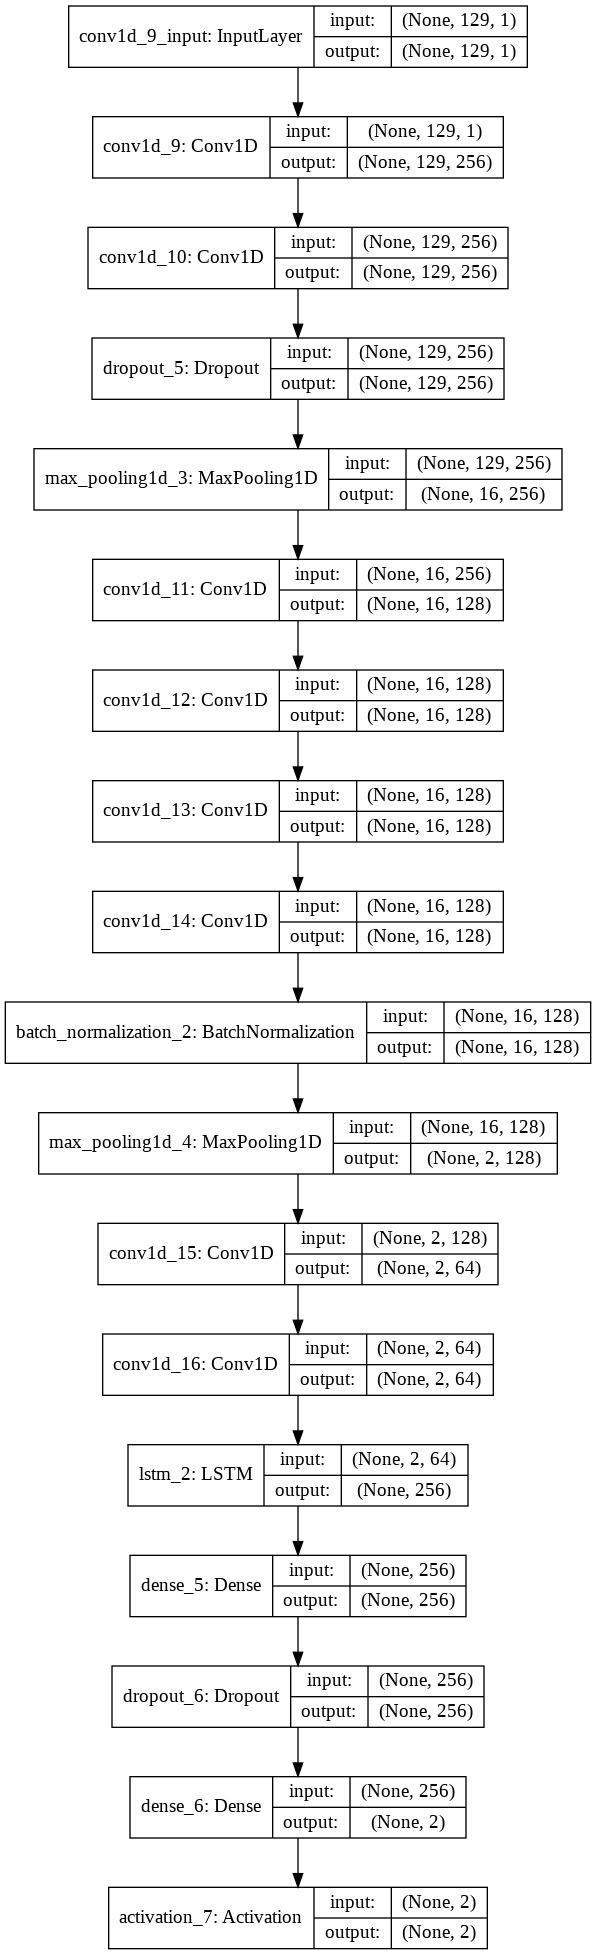

In [22]:
plot_model(model,show_shapes=True, to_file='onedmodel.png')

In [0]:
files.download('onedmodel.png')

In [0]:
history, score = fit_model(model,X_train, y_train,X_val, y_val)

Train on 2016 samples, validate on 504 samples
Epoch 1/100
2016/2016 [==============================] - 3s 2ms/step - loss: 1.6820 - accuracy: 0.2753 - val_loss: 1.6340 - val_accuracy: 0.2817
Epoch 2/100
2016/2016 [==============================] - 1s 735us/step - loss: 1.2220 - accuracy: 0.4940 - val_loss: 1.3715 - val_accuracy: 0.4365
Epoch 3/100
2016/2016 [==============================] - 1s 740us/step - loss: 0.8411 - accuracy: 0.6612 - val_loss: 0.9323 - val_accuracy: 0.6528
Epoch 4/100
2016/2016 [==============================] - 1s 732us/step - loss: 0.6509 - accuracy: 0.7545 - val_loss: 0.5901 - val_accuracy: 0.8194
Epoch 5/100
2016/2016 [==============================] - 2s 752us/step - loss: 0.3566 - accuracy: 0.8765 - val_loss: 0.5095 - val_accuracy: 0.8115
Epoch 6/100
2016/2016 [==============================] - 1s 736us/step - loss: 0.3518 - accuracy: 0.8720 - val_loss: 0.4582 - val_accuracy: 0.8413
Epoch 7/100
2016/2016 [==============================] - 2s 749us/step - 

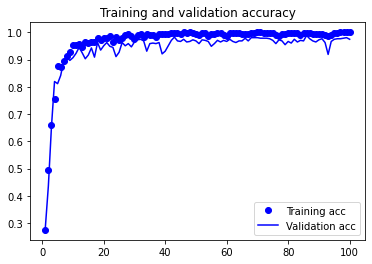

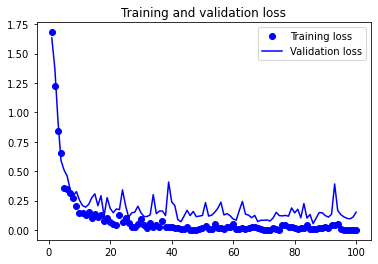

In [0]:
plot_model(history)

In [0]:
#use model to make predictions
preds = model.predict(X_test, 
                      batch_size=50, 
                      verbose=1)

preds=preds.argmax(axis=1)
preds

280/280 [==============================] - 0s 2ms/step


array([1, 3, 5, 3, 4, 2, 5, 5, 6, 0, 2, 2, 5, 5, 6, 5, 0, 5, 5, 5, 6, 2,
       5, 1, 2, 2, 6, 1, 3, 4, 2, 6, 5, 4, 5, 4, 4, 6, 0, 6, 3, 0, 5, 0,
       3, 3, 0, 6, 2, 0, 3, 3, 0, 1, 3, 0, 5, 3, 3, 0, 6, 1, 0, 5, 6, 3,
       5, 5, 1, 1, 0, 5, 3, 1, 5, 6, 4, 0, 3, 0, 5, 5, 4, 2, 3, 1, 2, 3,
       4, 5, 4, 2, 1, 6, 6, 6, 5, 5, 1, 4, 2, 4, 1, 3, 6, 0, 2, 5, 2, 5,
       6, 2, 3, 1, 0, 1, 3, 4, 0, 1, 6, 3, 4, 5, 1, 6, 0, 0, 1, 0, 4, 3,
       2, 4, 4, 0, 2, 3, 1, 2, 2, 4, 6, 3, 0, 0, 4, 3, 6, 4, 4, 4, 5, 1,
       0, 0, 2, 6, 1, 2, 0, 2, 2, 4, 1, 6, 2, 2, 6, 6, 2, 1, 3, 2, 0, 2,
       0, 3, 5, 6, 6, 6, 1, 0, 4, 0, 3, 3, 4, 5, 0, 0, 1, 2, 6, 2, 0, 3,
       0, 4, 3, 0, 2, 6, 4, 6, 5, 3, 1, 6, 0, 2, 4, 3, 3, 6, 1, 5, 5, 3,
       4, 4, 6, 5, 2, 2, 0, 1, 1, 5, 3, 6, 1, 3, 1, 4, 0, 0, 2, 6, 3, 0,
       2, 3, 1, 4, 3, 6, 2, 2, 3, 2, 0, 2, 2, 6, 0, 1, 4, 6, 0, 2, 3, 2,
       3, 4, 2, 1, 4, 0, 4, 3, 3, 1, 1, 4, 5, 1, 5, 3])

In [0]:
# view predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

preds

,predictedvalues
0,disgust
1,happy
2,sad
3,happy
4,neutral
...,...
275,neutral
276,sad
277,disgust
278,sad


In [0]:
#compare predicted to actual values

actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

finaldf = actual.join(preds)
finaldf

,actualvalues,predictedvalues
0,disgust,disgust
1,happy,happy
2,sad,sad
3,happy,happy
4,neutral,neutral
...,...,...
275,neutral,neutral
276,sad,sad
277,disgust,disgust
278,sad,sad


0.975


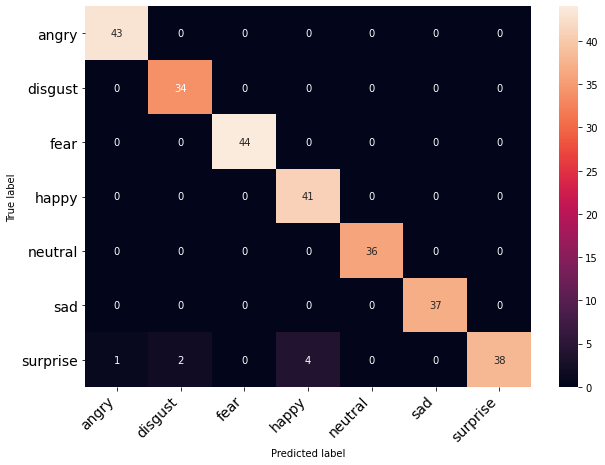

In [0]:
#view confusion matrix
classes = finaldf.actualvalues.unique()
classes.sort()    

c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [0]:
#save model
save_model(model,'oneDcnnall.h5','oneDcnnall')

Saving model and weights at /content/saved_models/oneDcnnall.h5 


**Train binary classifiers for each class**

In [0]:
#make binary representations for each class
binary_rep = iterator(y)

In [0]:
def prepare1D(X, y, lb):
    #split each into train, test and validation

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

    #convert to numpy array 
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_val = np.array(X_val)
    y_val = np.array(y_val)


    #reshape for CNN
    X_train = np.array([x.reshape((129,1)) for x in X_train])
    X_val = np.array([x.reshape((129,1)) for x in X_val])
    X_test = np.array([x.reshape((129,1)) for x in X_test])

    # one hot encode the target 
    y_train = keras.utils.to_categorical(lb.fit_transform(y_train))
    y_test = keras.utils.to_categorical(lb.fit_transform(y_test))
    y_val = keras.utils.to_categorical(lb.fit_transform(y_val))


    return X_train, y_train, X_test, y_test, X_val, y_val, lb

In [0]:
def binary_models(classname):
    #split data into test and train
    lb = LabelEncoder()
    X_train, y_train, X_test, y_test, X_val, y_val, lb = prepare1D(t, d, lb)

    #compile the model
    model = OneD_CNN_binary((129,1))

    #fit the model
    history, score = fit_model(model,X_train, y_train, X_val, y_val,50 )

    print(f"The accuracy of the model is {score[1]}")

    #save the model
    filename = classname + ".json"
    model_name = classname + ".h5"
    save_model(model,model_name,filename)

    return X_test, y_test, lb

In [28]:
model = OneD_CNN_binary((129,1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 129, 256)          2304      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 129, 256)          524544    
_________________________________________________________________
dropout_7 (Dropout)          (None, 129, 256)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 16, 256)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 16, 128)           262272    
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 16, 128)           131200    
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16, 128)          

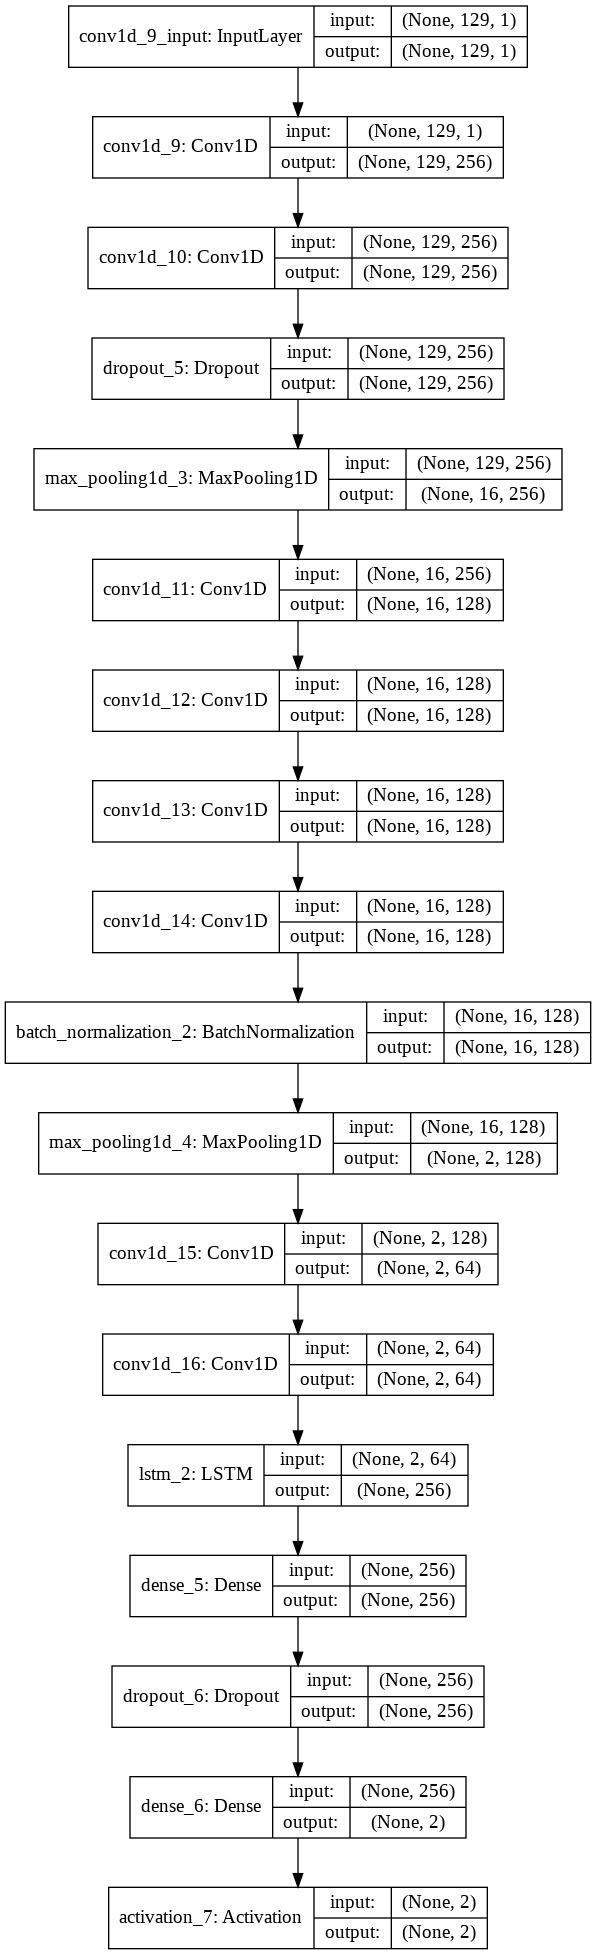

In [24]:
plot_model(model, show_shapes=True,to_file='binaryoned.png')

In [0]:
files.download('binaryoned.png')

In [0]:
all_binary_models = []

for d in binary_rep:
    #get unique classes
    classes = unique(d)
    if classes[1] == 'other':
        classname = classes[0]
    else:
        classname = classes[1]

    model_result = binary_models(classname)
    all_binary_models.append(model_result)

Train on 2016 samples, validate on 504 samples
Epoch 1/50
2016/2016 [==============================] - 3s 1ms/step - loss: 0.2961 - accuracy: 0.8715 - val_loss: 0.2324 - val_accuracy: 0.8869
Epoch 2/50
2016/2016 [==============================] - 1s 736us/step - loss: 0.1837 - accuracy: 0.9276 - val_loss: 0.2514 - val_accuracy: 0.9107
Epoch 3/50
2016/2016 [==============================] - 1s 733us/step - loss: 0.1451 - accuracy: 0.9410 - val_loss: 0.2069 - val_accuracy: 0.8948
Epoch 4/50
2016/2016 [==============================] - 1s 734us/step - loss: 0.0659 - accuracy: 0.9772 - val_loss: 0.1062 - val_accuracy: 0.9603
Epoch 5/50
2016/2016 [==============================] - 2s 747us/step - loss: 0.0497 - accuracy: 0.9846 - val_loss: 0.1429 - val_accuracy: 0.9226
Epoch 6/50
2016/2016 [==============================] - 1s 729us/step - loss: 0.0477 - accuracy: 0.9846 - val_loss: 0.0957 - val_accuracy: 0.9603
Epoch 7/50
2016/2016 [==============================] - 1s 737us/step - loss: 0

In [0]:
len(all_binary_models)

7

**Evaluate binary models**

Evaluate fear model

In [0]:
len(all_binary_models[0])
fear_data = all_binary_models[0]

In [0]:
fearmodel =load_model("fear.json", "fear.h5")

Loaded model from disk


In [0]:
predf = fearmodel.predict(fear_data[0])
predf=predf.argmax(axis=1)
predf

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [0]:
# view predictions 
predf = predf.astype(int).flatten()
predf = (fear_data[2].inverse_transform((predf)))
predf = pd.DataFrame({'predictedvalues': predf})

predf

,predictedvalues
0,other
1,other
2,other
3,other
4,other
...,...
275,other
276,other
277,other
278,other


In [0]:
#compare predicted to actual values

actual = fear_data[1].argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (fear_data[2].inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

finaldf = actual.join(predf)
finaldf

,actualvalues,predictedvalues
0,other,other
1,other,other
2,other,other
3,other,other
4,other,other
...,...,...
275,other,other
276,other,other
277,other,other
278,other,other


0.9964285714285714


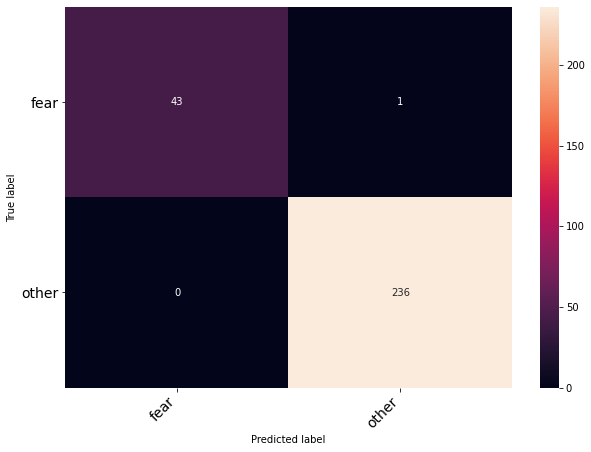

In [0]:
#view confusion matrix
classes = finaldf.actualvalues.unique()
classes.sort()    

c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

Evaluate surprise model

In [0]:
surprise_data = all_binary_models[1]

In [0]:
surprisemodel =load_model("surprise.json", "surprise.h5")

Loaded model from disk


In [0]:
predsu = surprisemodel.predict(surprise_data[0])
predsu=predsu.argmax(axis=1)
predsu

array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
# view predictions 
predsu = predsu.astype(int).flatten()
predsu = (surprise_data[2].inverse_transform((predsu)))
predsu = pd.DataFrame({'predictedvalues': predsu})

predsu

,predictedvalues
0,other
1,other
2,other
3,surprise
4,other
...,...
275,other
276,other
277,other
278,other


In [0]:
#compare predicted to actual values

actual = surprise_data[1].argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (surprise_data[2].inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

finaldf = actual.join(predsu)
finaldf

,actualvalues,predictedvalues
0,other,other
1,other,other
2,other,other
3,other,surprise
4,other,other
...,...,...
275,other,other
276,other,other
277,other,other
278,other,other


0.9785714285714285


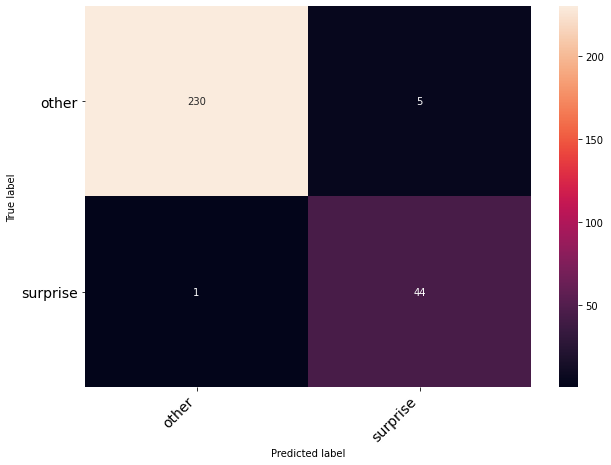

In [0]:
#view confusion matrix
classes = finaldf.actualvalues.unique()
classes.sort()    

c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

Evaluate sad model

In [0]:
sad_data = all_binary_models[2]

In [0]:
sadmodel =load_model("sad.json", "sad.h5")

Loaded model from disk


In [0]:
predsa = sadmodel.predict(sad_data[0])
predsa=predsa.argmax(axis=1)
predsa

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [0]:
# view predictions 
predsa = predsa.astype(int).flatten()
predsa = (sad_data[2].inverse_transform((predsa)))
predsa = pd.DataFrame({'predictedvalues': predsa})

predsa

,predictedvalues
0,other
1,other
2,sad
3,other
4,other
...,...
275,other
276,sad
277,other
278,sad


In [0]:
#compare predicted to actual values

actual = sad_data[1].argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (sad_data[2].inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

finaldf = actual.join(predsa)
finaldf

,actualvalues,predictedvalues
0,other,other
1,other,other
2,sad,sad
3,other,other
4,other,other
...,...,...
275,other,other
276,sad,sad
277,other,other
278,sad,sad


0.9892857142857143


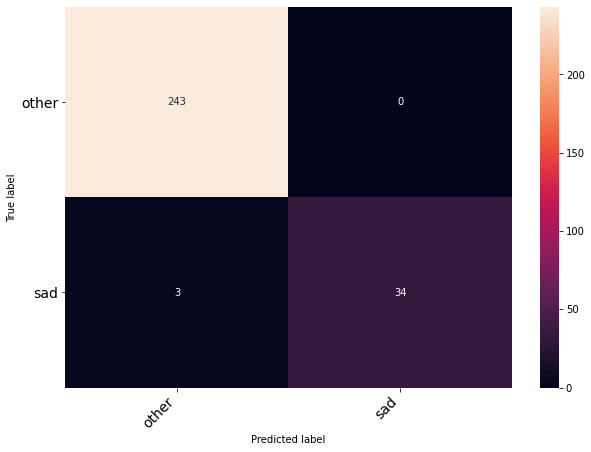

In [0]:
#view confusion matrix
classes = finaldf.actualvalues.unique()
classes.sort()    

c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

Evaluate angry model

In [0]:
angry_data = all_binary_models[3]

In [0]:
angrymodel =load_model("angry.json", "angry.h5")

Loaded model from disk


In [0]:
predan = angrymodel.predict(angry_data[0])
predan=predan.argmax(axis=1)
predan

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [0]:
# view predictions 
predan = predan.astype(int).flatten()
predan = (angry_data[2].inverse_transform((predan)))
predan = pd.DataFrame({'predictedvalues': predan})

predan

,predictedvalues
0,other
1,other
2,other
3,other
4,other
...,...
275,other
276,other
277,other
278,other


In [0]:
#compare predicted to actual values

actual = angry_data[1].argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (angry_data[2].inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

finaldf = actual.join(predan)
finaldf

,actualvalues,predictedvalues
0,other,other
1,other,other
2,other,other
3,other,other
4,other,other
...,...,...
275,other,other
276,other,other
277,other,other
278,other,other


0.9964285714285714


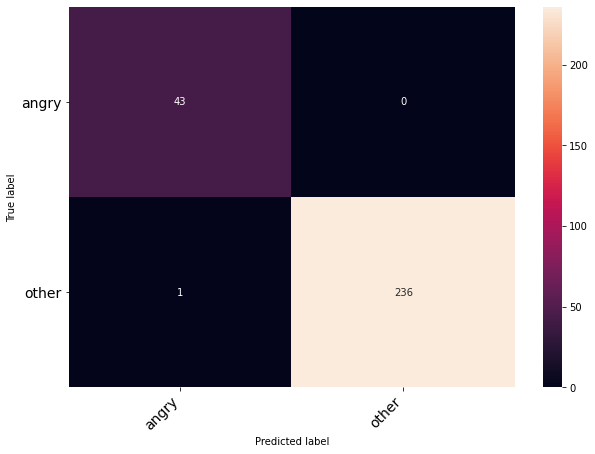

In [0]:
#view confusion matrix
classes = finaldf.actualvalues.unique()
classes.sort()    

c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

Evaluate disgust model

In [0]:
disgust_data = all_binary_models[4]

In [0]:
disgustmodel =load_model("disgust.json", "disgust.h5")

Loaded model from disk


In [0]:
preddi = disgustmodel.predict(disgust_data[0])
preddi=preddi.argmax(axis=1)
preddi

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1])

In [0]:
# view predictions 
preddi = preddi.astype(int).flatten()
preddi = (disgust_data[2].inverse_transform((preddi)))
preddi = pd.DataFrame({'predictedvalues': preddi})

preddi

,predictedvalues
0,disgust
1,other
2,other
3,other
4,other
...,...
275,other
276,other
277,disgust
278,other


In [0]:
#compare predicted to actual values

actual = disgust_data[1].argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (disgust_data[2].inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

finaldf = actual.join(preddi)
finaldf

,actualvalues,predictedvalues
0,disgust,disgust
1,other,other
2,other,other
3,other,other
4,other,other
...,...,...
275,other,other
276,other,other
277,disgust,disgust
278,other,other


0.9821428571428571


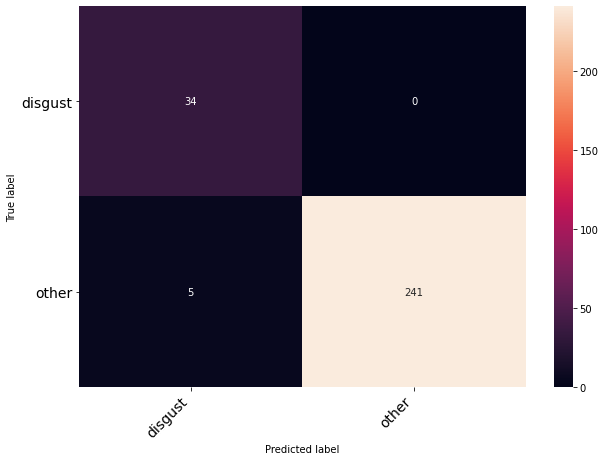

In [0]:
#view confusion matrix
classes = finaldf.actualvalues.unique()
classes.sort()    

c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

Evaluate happy model

In [0]:
happy_data = all_binary_models[5]

In [0]:
happymodel =load_model("happy.json", "happy.h5")

Loaded model from disk


In [0]:
predha = happymodel.predict(happy_data[0])
predha=predha.argmax(axis=1)
predha

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0])

In [0]:
 # view predictions 
predha = predha.astype(int).flatten()
predha = (happy_data[2].inverse_transform((predha)))
predha = pd.DataFrame({'predictedvalues': predha})

predha

,predictedvalues
0,other
1,happy
2,other
3,other
4,other
...,...
275,other
276,other
277,other
278,other


In [0]:
#compare predicted to actual values

actual = happy_data[1].argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (happy_data[2].inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

finaldf = actual.join(predha)
finaldf

,actualvalues,predictedvalues
0,other,other
1,happy,happy
2,other,other
3,happy,other
4,other,other
...,...,...
275,other,other
276,other,other
277,other,other
278,other,other


0.9785714285714285


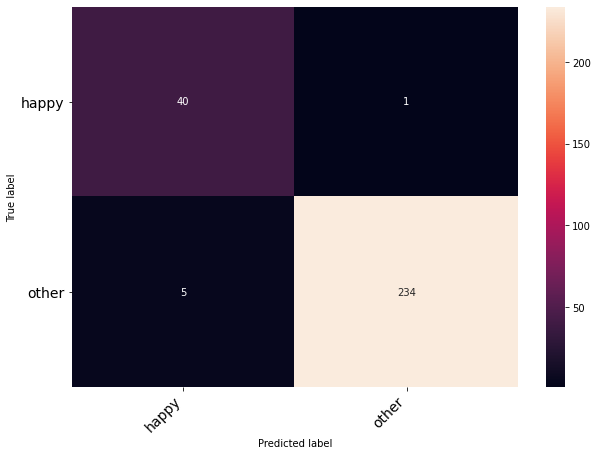

In [0]:
#view confusion matrix
classes = finaldf.actualvalues.unique()
classes.sort()    

c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

Evaluate neutral model

In [0]:
neutral_data = all_binary_models[6]

In [0]:
neutralmodel =load_model("neutral.json", "neutral.h5")

Loaded model from disk


In [0]:
predne = neutralmodel.predict(neutral_data[0])
predne=predne.argmax(axis=1)
predne

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [0]:
 # view predictions 
predne = predne.astype(int).flatten()
predne = (neutral_data[2].inverse_transform((predne)))
predne = pd.DataFrame({'predictedvalues': predne})

predne

,predictedvalues
0,other
1,other
2,other
3,other
4,neutral
...,...
275,neutral
276,other
277,other
278,other


In [0]:
#compare predicted to actual values

actual = neutral_data[1].argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (neutral_data[2].inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

finaldf = actual.join(predne)
finaldf

,actualvalues,predictedvalues
0,other,other
1,other,other
2,other,other
3,other,other
4,neutral,neutral
...,...,...
275,neutral,neutral
276,other,other
277,other,other
278,other,other


1.0


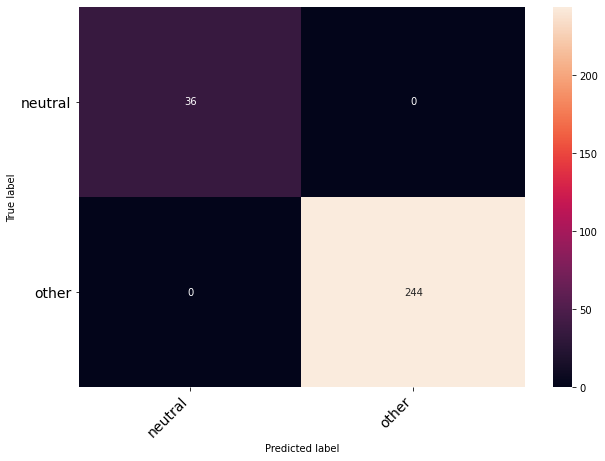

In [0]:
#view confusion matrix
classes = finaldf.actualvalues.unique()
classes.sort()    

c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

**Ensemble all 7 models**

In [0]:
# load models from file
models = []
emotions = ['fear', 'surprise', 'sad', 'angry', 'disgust', 'happy', 'neutral']
for i in emotions:
  model = load_model(i+".json", i+".h5")
  models.append(model)

Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk


In [0]:
model_preds = []
for model in models:
 p = model.predict(X_test)
 model_preds.append(p)

In [0]:
model_preds[0].shape

(280, 2)

In [0]:
r = np.hstack(model_preds)

In [0]:
r.shape

(280, 14)

In [0]:
xx_train, xx_test, yy_train, yy_test = train_test_split(r, y_test, test_size=0.3, random_state=1)

In [17]:
#do a small metalearner to learn from the predictions of the binary classifiers
meta = Sequential()

meta.add(Dense(32, activation="relu", input_dim=(14)))
meta.add(Dense(32, activation="relu"))
meta.add(Dense(7))
meta.add(Activation("softmax"))

meta.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                480       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 231       
_________________________________________________________________
activation_8 (Activation)    (None, 7)                 0         
Total params: 1,767
Trainable params: 1,767
Non-trainable params: 0
_________________________________________________________________


In [0]:
meta.compile(optimizer="Adam",
             loss = "categorical_crossentropy",
             metrics=["accuracy"])


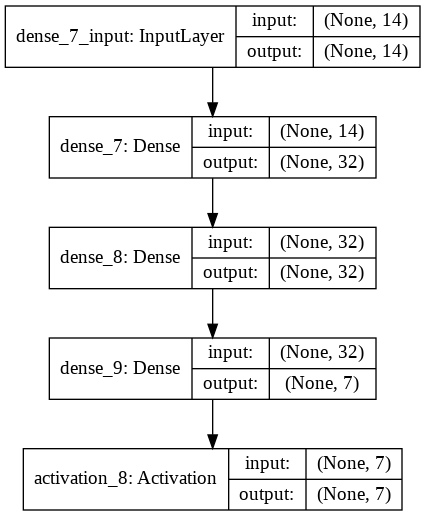

In [26]:
plot_model(meta,show_shapes=True, to_file='meta.png')

In [0]:
files.download('meta.png')

In [0]:
history = meta.fit(x=xx_train,
            y = yy_train,
            epochs=50,
            batch_size=50,
            
            validation_data = (xx_test, yy_test))

score = meta.evaluate(x = xx_test,
                        y = yy_test)

print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Train on 196 samples, validate on 84 samples
Epoch 1/50
196/196 [==============================] - 0s 684us/step - loss: 1.9461 - accuracy: 0.1633 - val_loss: 1.8703 - val_accuracy: 0.5714
Epoch 2/50
196/196 [==============================] - 0s 125us/step - loss: 1.8994 - accuracy: 0.5000 - val_loss: 1.8292 - val_accuracy: 0.5714
Epoch 3/50
196/196 [==============================] - 0s 133us/step - loss: 1.8572 - accuracy: 0.5102 - val_loss: 1.7939 - val_accuracy: 0.5714
Epoch 4/50
196/196 [==============================] - 0s 130us/step - loss: 1.8164 - accuracy: 0.5102 - val_loss: 1.7594 - val_accuracy: 0.5714
Epoch 5/50
196/196 [==============================] - 0s 117us/step - loss: 1.7785 - accuracy: 0.5102 - val_loss: 1.7274 - val_accuracy: 0.5714
Epoch 6/50
196/196 [==============================] - 0s 114us/step - loss: 1.7413 - accuracy: 0.5102 - val_loss: 1.6930 - val_accuracy: 0.5714
Epoch 7/50
196/196 [==============================] - 0s 166us/step - loss: 1.7034 - accura

Final accuracy of ensembled learners : 98.8%